**Changing the directory** 

In [ ]:
cd '/content/drive/MyDrive/NasrAbadi/Miss-Match detection/StratifiedGroupFold'

/content/drive/.shortcut-targets-by-id/1QjZ52EqSaXzJIHNRgjdB-qbPUcReg_SP/NasrAbadi/Miss-Match detection/StratifiedGroupFold


**Loading the data**

In [ ]:
import numpy as np
X_train = np.load('X_train.npy')
Y_train = np.load('Y_train.npy')

X_test = np.load('X_test.npy')
Y_test = np.load('Y_test.npy')


X_val = np.load('X_val.npy')
Y_val = np.load('Y_val.npy')

Group_test = np.load('Group_test.npy')


print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

print(Y_train.shape)
print(Y_test.shape)
print(Y_val.shape)
print(Y_train)
print(Group_test)

(5298, 1, 19, 1280)
(1406, 1, 19, 1280)
(1212, 1, 19, 1280)
(5298,)
(1406,)
(1212,)
[0 0 0 ... 1 1 1]
[[ 10]
 [ 10]
 [ 10]
 ...
 [118]
 [118]
 [118]]


**Changing the data to categorical type**

In [ ]:
# EEGNet-specific imports
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K

############################# EEGNet portion ##################################
# convert labels to one-hot encodings.


Y_train      = np_utils.to_categorical(Y_train)
Y_val        = np_utils.to_categorical(Y_val)
Y_test       = np_utils.to_categorical(Y_test)

**Change the channels to first**

In [ ]:
from tensorflow.keras import backend as K
K.set_image_data_format('channels_first')

**Installing Required Packages**

In [ ]:
!pip install keras_tuner
!pip install pyriemann

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 KB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.0/365.0 KB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyriemann: filename=pyriemann-0.3-py2.py3-none-any.whl size=78032 sha256=5a6372632422e55c836eb22866778a08eb79f1ee36a44b1dcc881e6998f6f14e
  Stored in directory: /root/.cache/pip/wheels/8f/08/26/3bee80f73136e2669b530a30dade9ae56422203a09e0400995
Successfully built pyriemann


**Building the Model**

In [ ]:
import keras_tuner
from kerastuner.tuners import BayesianOptimization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K

def EEGNet(hp, nb_classes =2 , dropoutRate = 0.5, dropoutType = 'Dropout'):
      
  if dropoutType == 'SpatialDropout2D':
      dropoutType = SpatialDropout2D
  elif dropoutType == 'Dropout':
      dropoutType = Dropout
  else:
      raise ValueError('dropoutType must be one of SpatialDropout2D '
                      'or Dropout, passed as a string.')
  input1   = Input(shape = (1, 19, 1280))
  block1       = Conv2D(hp.Choice('F1', values=[8, 16]), (1, hp.Choice('kernLength', values=[32, 64, 128, 256])), padding = 'same',
                                   input_shape = (1, 19, 1280),
                                   use_bias = False)(input1)
  block1       = BatchNormalization(axis = 1)(block1)

  block1       = DepthwiseConv2D((19, 1), use_bias = False, 
                                  depth_multiplier = hp.Choice('D', values=[2]),
                                  depthwise_constraint = max_norm(1.))(block1)
  block1       = BatchNormalization(axis = 1)(block1)
  block1       = Activation('elu')(block1)
  block1       = AveragePooling2D((1, 4))(block1)
  block1       = dropoutType(dropoutRate)(block1)
  
  block2       = SeparableConv2D(hp.Choice('F2', values=[16, 32]), (1, 16),
                                  use_bias = False, padding = 'same')(block1)
  block2       = BatchNormalization(axis = 1)(block2)
  block2       = Activation('elu')(block2)
  block2       = AveragePooling2D((1, 8))(block2)
  block2       = dropoutType(dropoutRate)(block2)
      
  flatten      = Flatten(name = 'flatten')(block2)
  
  dense        = Dense(nb_classes, name = 'dense', 
                        kernel_constraint = max_norm(hp.Choice('norm_rate', values=[0.25, 0.5, 1.0, 5.0])))(flatten)
  softmax      = Activation('softmax', name = 'softmax')(dense)
  
  model = Model(inputs=input1, outputs=softmax)
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
  return model
  
    

In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam
import math

adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
keras_reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.0001, verbose=2)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
path = '/content/drive/MyDrive/NasrAbadi/Miss-Match detection/StratifiedGroupFold/Best Model Saved'
checkpoint = ModelCheckpoint(path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
mt = BayesianOptimization(EEGNet,objective='val_accuracy',max_trials = 5)
mt.search(X_train, Y_train,  
              epochs=10, # small number for quick run
              batch_size=32,
              callbacks = [es, keras_reduce_lr], 
              validation_data=(X_val, Y_val))

Trial 5 Complete [00h 00m 50s]
val_accuracy: 0.9158415794372559

Best val_accuracy So Far: 0.9628713130950928
Total elapsed time: 00h 04m 44s


In [ ]:
mt.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
F1: 16
kernLength: 256
D: 2
F2: 16
norm_rate: 0.25
Score: 0.9628713130950928
Trial summary
Hyperparameters:
F1: 16
kernLength: 256
D: 2
F2: 32
norm_rate: 0.5
Score: 0.9537953734397888
Trial summary
Hyperparameters:
F1: 16
kernLength: 256
D: 2
F2: 16
norm_rate: 5.0
Score: 0.9216171503067017
Trial summary
Hyperparameters:
F1: 16
kernLength: 256
D: 2
F2: 32
norm_rate: 0.25
Score: 0.9158415794372559
Trial summary
Hyperparameters:
F1: 8
kernLength: 32
D: 2
F2: 32
norm_rate: 1.0
Score: 0.9067656993865967


In [ ]:
best_model  = mt.get_best_models(num_models=1)[0]
probs       = best_model.predict(X_test)
preds       = probs.argmax(axis = -1)  
acc         = np.mean(preds == Y_test.argmax(axis=-1))
print("Classification accuracy: %f " % (acc))
best_model.summary()

44/44 [==============================] - 1s 17ms/step
Classification accuracy: 0.863442 
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 19, 1280)]     0         
                                                                 
 conv2d (Conv2D)             (None, 16, 19, 1280)      4096      
                                                                 
 batch_normalization (BatchN  (None, 16, 19, 1280)     64        
 ormalization)                                                   
                                                                 
 depthwise_conv2d (Depthwise  (None, 32, 1, 1280)      608       
 Conv2D)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 32, 1, 1280)      128       
 hNormalization)                      

**Calculating the accuracy and F-measure for each subject**

In [ ]:
import matplotlib.pyplot as plt
def subject_classification(y_true, y_pred, group, accuracy_type = 'max_vote'):
  """
  y_pred should be the output of 'model.predict' using 2 nodes in the dense layer and softmax activation.
  """
  from pyriemann.utils.viz import plot_confusion_matrix

  #Categorical to normal labeling
  y_true = y_true.argmax(axis=-1)
  probability = np.array(probs)
  prediction = probs.argmax(axis = -1)
  max_vote = []
  subject_traget = []
  j = 0
  unique, counts = np.unique(Group_test, return_counts=True)
  mean_ = np.zeros([len(unique),2], dtype='float32')
  for i in range(len(unique)):
    for k in range(2):
      mean_[i][k] = np.mean(probability[j:j+counts[i]-1,k])
    c = np.bincount(prediction[j:j+counts[i]-1])
    max_vote.append(np.argmax(c))
    subject_traget.append(y_true[j])
    j = j + counts[i]
  mean_       = mean_.argmax(axis = -1)
  max_vote = np.array(max_vote)
  subject_traget = np.array(subject_traget)
  acc_max_vote         = np.mean(max_vote == subject_traget)
  acc_mean         = np.mean(mean_ == subject_traget)
  if accuracy_type == 'max_vote':
    names        = ['ADHD','Control']
    plt.figure(0)
    plot_confusion_matrix(subject_traget, max_vote, names, title = 'Max Vote Type')
    return acc_max_vote
  elif accuracy_type == 'mean':
    names        = ['ADHD','Control']
    plt.figure(0)
    plot_confusion_matrix(subject_traget, mean_, names, title = 'Mean Type')
    return acc_mean
  else:
    raise ValueError('You have not entered an accurate type!')

**Evaluating on the test set and subject-wise**

0.85
0.85


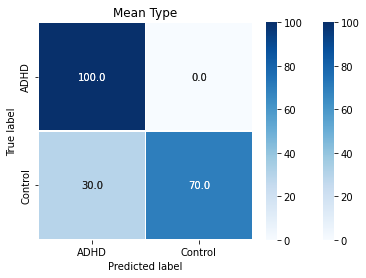

In [ ]:
acc_max = subject_classification(Y_test, probs, Group_test, accuracy_type = 'max_vote')
acc_mean = subject_classification(Y_test, probs, Group_test, accuracy_type = 'mean')
print(acc_max)
print(acc_mean)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K
from keras.models import load_model


def EEGNet(nb_classes=2, Chans = 19, Samples = 1280, 
             dropoutRate = 0.5, kernLength = 64, F1 = 16, 
             D = 2, F2 = 32, norm_rate = 1.0, dropoutType = 'Dropout'):
    
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = Input(shape = (1, Chans, Samples))

    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (1, Chans, Samples),
                                   use_bias = False)(input1)
    block1       = BatchNormalization(axis = 1)(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization(axis = 1)(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)
    
    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization(axis = 1)(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8))(block2)
    block2       = dropoutType(dropoutRate)(block2)
        
    flatten      = Flatten(name = 'flatten')(block2)
    
    dense        = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    
    return Model(inputs=input1, outputs=softmax)


In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam
import math

adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
keras_reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.0001, verbose=2)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
path = '/content/drive/MyDrive/NasrAbadi/Miss-Match detection/StratifiedGroupFold/Best Model Saved'
checkpoint = ModelCheckpoint(path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

**Defining and Fitting the model**

In [ ]:
kernels, chans, samples = 1, 19, 1280
model = EEGNet(nb_classes = 2, Chans = chans, Samples = samples, 
               dropoutRate = 0.5, kernLength = 64, F1 = 16, D = 2, F2 = 32, 
               norm_rate = 1.0, dropoutType = 'Dropout')
# compile the model and set the optimizers
model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
fittedModel = model.fit(X_train, Y_train, batch_size = 32, epochs = 100, 
                        verbose = 2, validation_data=(X_val, Y_val), callbacks=[es, keras_reduce_lr, checkpoint])


Epoch 1/100

Epoch 1: val_accuracy improved from -inf to 0.83003, saving model to /content/drive/MyDrive/NasrAbadi/Miss-Match detection/StratifiedGroupFold/Best Model Saved


166/166 - 8s - loss: 0.4255 - accuracy: 0.8084 - val_loss: 0.3584 - val_accuracy: 0.8300 - lr: 0.0010 - 8s/epoch - 50ms/step
Epoch 2/100

Epoch 2: val_accuracy improved from 0.83003 to 0.93647, saving model to /content/drive/MyDrive/NasrAbadi/Miss-Match detection/StratifiedGroupFold/Best Model Saved


166/166 - 4s - loss: 0.1133 - accuracy: 0.9572 - val_loss: 0.1579 - val_accuracy: 0.9365 - lr: 0.0010 - 4s/epoch - 26ms/step
Epoch 3/100

Epoch 3: val_accuracy improved from 0.93647 to 0.94142, saving model to /content/drive/MyDrive/NasrAbadi/Miss-Match detection/StratifiedGroupFold/Best Model Saved


166/166 - 4s - loss: 0.0621 - accuracy: 0.9790 - val_loss: 0.1436 - val_accuracy: 0.9414 - lr: 0.0010 - 4s/epoch - 25ms/step
Epoch 4/100

Epoch 4: val_accuracy improved from 0.94142 to 0.96205, saving model to /content/drive/MyDrive/NasrAbadi/Miss-Match detection/StratifiedGroupFold/Best Model Saved


166/166 - 5s - loss: 0.0338 - accuracy: 0.9891 - val_loss: 0.1046 - val_accuracy: 0.9620 - lr: 0.0010 - 5s/epoch - 27ms/step
Epoch 5/100

Epoch 5: val_accuracy did not improve from 0.96205
166/166 - 3s - loss: 0.0371 - accuracy: 0.9883 - val_loss: 0.2253 - val_accuracy: 0.9620 - lr: 0.0010 - 3s/epoch - 17ms/step
Epoch 6/100

Epoch 6: val_accuracy improved from 0.96205 to 0.96452, saving model to /content/drive/MyDrive/NasrAbadi/Miss-Match detection/StratifiedGroupFold/Best Model Saved


166/166 - 4s - loss: 0.0275 - accuracy: 0.9917 - val_loss: 0.2739 - val_accuracy: 0.9645 - lr: 0.0010 - 4s/epoch - 26ms/step
Epoch 7/100

Epoch 7: val_accuracy did not improve from 0.96452
166/166 - 3s - loss: 0.0208 - accuracy: 0.9934 - val_loss: 0.2247 - val_accuracy: 0.9488 - lr: 0.0010 - 3s/epoch - 17ms/step
Epoch 8/100

Epoch 8: val_accuracy did not improve from 0.96452
166/166 - 3s - loss: 0.0159 - accuracy: 0.9953 - val_loss: 0.1986 - val_accuracy: 0.9645 - lr: 0.0010 - 3s/epoch - 18ms/step
Epoch 9/100

Epoch 9: val_accuracy did not improve from 0.96452
166/166 - 3s - loss: 0.0132 - accuracy: 0.9964 - val_loss: 0.1632 - val_accuracy: 0.9563 - lr: 0.0010 - 3s/epoch - 17ms/step
Epoch 10/100

Epoch 10: val_accuracy did not improve from 0.96452
166/166 - 3s - loss: 0.0165 - accuracy: 0.9947 - val_loss: 0.1494 - val_accuracy: 0.9587 - lr: 0.0010 - 3s/epoch - 17ms/step
Epoch 11/100

Epoch 11: val_accuracy improved from 0.96452 to 0.96617, saving model to /content/drive/MyDrive/NasrAba

166/166 - 4s - loss: 0.0185 - accuracy: 0.9943 - val_loss: 0.0987 - val_accuracy: 0.9662 - lr: 0.0010 - 4s/epoch - 25ms/step
Epoch 12/100

Epoch 12: val_accuracy did not improve from 0.96617
166/166 - 3s - loss: 0.0148 - accuracy: 0.9947 - val_loss: 0.1562 - val_accuracy: 0.9645 - lr: 0.0010 - 3s/epoch - 17ms/step
Epoch 13/100

Epoch 13: val_accuracy did not improve from 0.96617
166/166 - 3s - loss: 0.0126 - accuracy: 0.9957 - val_loss: 0.2477 - val_accuracy: 0.9604 - lr: 0.0010 - 3s/epoch - 17ms/step
Epoch 14/100

Epoch 14: val_accuracy did not improve from 0.96617
166/166 - 3s - loss: 0.0116 - accuracy: 0.9958 - val_loss: 0.3489 - val_accuracy: 0.9645 - lr: 0.0010 - 3s/epoch - 18ms/step
Epoch 15/100

Epoch 15: val_accuracy did not improve from 0.96617
166/166 - 3s - loss: 0.0093 - accuracy: 0.9974 - val_loss: 0.2900 - val_accuracy: 0.9604 - lr: 0.0010 - 3s/epoch - 17ms/step
Epoch 16/100

Epoch 16: val_accuracy did not improve from 0.96617
166/166 - 3s - loss: 0.0152 - accuracy: 0.995

In [ ]:
del fittedModel
path         = '/content/drive/MyDrive/NasrAbadi/Miss-Match detection/StratifiedGroupFold/Best Model Saved'
best         = load_model(path)
probs1       = best.predict(X_test)
### Convering One-Hot to simple labeling ###
preds1       = probs1.argmax(axis = -1)  
### Calculating Sample accuracy ###
acc1         = np.mean(preds1 == Y_test.argmax(axis=-1))
print("Classification accuracy: %f " % (acc1))

44/44 [==============================] - 0s 5ms/step
Classification accuracy: 0.868421 


0.95
0.95


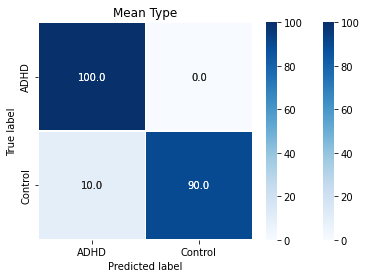

In [ ]:
acc_max1 = subject_classification(Y_test, probs1, Group_test, accuracy_type = 'max_vote')
acc_mean1 = subject_classification(Y_test, probs1, Group_test, accuracy_type = 'mean')
print(acc_max1)
print(acc_mean1)